In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
# Detection function
def mediapipe_detection(image, model):
    # Converts BGR to RGB color
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Sets image to unwriteable status
    image.flags.writeable = False 

    # Makes detection
    results = model.process(image) 

    # Sets image back to writeable status
    image.flags.writeable = True 

    # Convert back to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 

    # Return image and results back to loop
    return image, results 

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1,circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1,circle_radius=1))

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(80,22,10), thickness=2,circle_radius=4),
                              mp_drawing.DrawingSpec(color=(80,44,121), thickness=2,circle_radius=2))

    # Draw left-hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(121,22,76), thickness=2,circle_radius=4),
                              mp_drawing.DrawingSpec(color=(121,44,250), thickness=2,circle_radius=2))

    # Draw right-hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66), thickness=2,circle_radius=4),
                              mp_drawing.DrawingSpec(color=(245,66,230), thickness=2,circle_radius=2))

In [225]:
# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # While camera is opened
    while capture.isOpened():
        # Reads feed
        ret, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks on live video
        draw_styled_landmarks(image, results)

        #Shows to screen
        cv2.imshow('Open Camera Feed', image)

        # Break when 'q' pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    # Releases camera feed, closes all windows
    capture.release()
    cv2.destroyAllWindows()

In [226]:
draw_landmarks(frame, results)

In [227]:
result_test = extract_keypoints(results)

In [228]:
result_test

array([ 0.55628103,  0.75923401, -1.0427103 , ...,  0.54695147,
        0.12526956, -0.0433061 ])

In [229]:
np.save('0', result_test)

In [230]:
np.load('0.npy')

array([ 0.55628103,  0.75923401, -1.0427103 , ...,  0.54695147,
        0.12526956, -0.0433061 ])

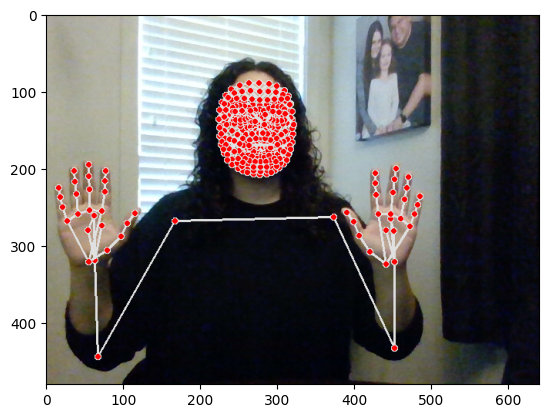

In [94]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [5]:
# Function to extract keypoints, if none found creates array of zeros
def extract_keypoints(results):
    
    # Extracts pose keypoints into one array, if none found creates array of zeros to copy shape for error handling
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

    # Extracts face keypoints, if none found creates array of zeros to copy shape for error handling
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    
    # Extracts left hand keypoints, if none found creates array of zeros to copy shape for error handling
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    
    # Extracts right hand landmarks, if none found creates array of zeros to copy shape for error handling
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, left_hand, right_hand])

DATA COLLECTION
Originally this function contained all the different gestures and was modified. Therefore it originally appeared after paths and sequences were created. After the code was changed to fit multiple models with less gestures for lessons in the Streamlit application, the code that sets paths was added, which is why some variables in the following appear not to be instantiated prior to use. 

In [153]:
# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through actions
    for action in actions:

        #Loop though sequences
        for sequence in range(num_sequences):

            #Loop through video length
            for frame_num in range(sequence_length):
                
                # Reads feed
                ret, frame = capture.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks on live video
                draw_styled_landmarks(image, results)

                # Provides break for repositioning on first frame
                
                # If frame is first frame
                if frame_num == 0:
                    # Outprints to screen to show frames being collected
                    cv2.putText(image, 'COLLECTION STARTING', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

                    # Take 2 second break between each video
                    cv2.waitKey(2000)

                else:
                    # Prints out image currently collecting
                     cv2.putText(image, 'Collecting frames for {} Video number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)

                # Exports keypoints
                keypoints = extract_keypoints(results)

                # Creates path
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))

                # Saves keypoints 
                np.save(npy_path, keypoints)
                
                #Shows to screen
                cv2.imshow('Open Camera Feed', image)

                # Break when 'q' pressed
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    # Releases camera feed, closes all windows
    capture.release()
    cv2.destroyAllWindows()

LESSON 1 MODEL

In [28]:
# Sets path for exported data (numpy arrays)
DATA_PATH = os.path.join('lesson1')

# Actions to detect (x actions multiplied by 30 frames multiplied by 30 sequences)
lesson1_actions = np.array(['again', 'alive', 'dad', 'family', 'friend', 'hard_of_hearing', 'help_me', 'how', 'hungry', 'like'])

# Number of videos
num_sequences = 30

# Number of frames
sequence_length = 30

In [29]:
# Loops through all actions and makes directories for them
for action in lesson1_actions:
    # loop through videos
    for sequence in range(num_sequences):
        # Creates new folders and makes directories with subfolders, skips if folder already created
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [30]:
# Creates a dictionary of labels
lesson1_label_map = {label:num for num, label in enumerate(lesson1_actions)}

In [31]:
lesson1_label_map

{'again': 0,
 'alive': 1,
 'dad': 2,
 'family': 3,
 'friend': 4,
 'hard_of_hearing': 5,
 'help_me': 6,
 'how': 7,
 'hungry': 8,
 'like': 9}

In [32]:
# Array of sequences (features) used to train model to represent relationship between labels
lesson1_sequences, lesson1_labels = [], []

# loops through each action
for action in lesson1_actions:

    # Loops through each sequence
    for sequence_index in range(num_sequences):

        # Blank array to represent all frames for particular sequence
        window = []

        # Loops through each frame
        for frame_num in range(sequence_length):

            # Loads frame
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_index), "{}.npy".format(frame_num)))

            # Add frames to window
            window.append(res)

        # Append video to sequences
        lesson1_sequences.append(window)

        # Append lables
        lesson1_labels.append(lesson1_label_map[action])

In [33]:
# Stores sequences in array to make it easier to work with, uses x for x / y values
x_lesson1 = np.array(lesson1_sequences)

In [34]:
x_lesson1.shape

(300, 30, 1662)

In [15]:
# Allows training into partitions for training and testing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [36]:
# Stores sequences in array to make it easier to work with, uses x for x / y values
x_lesson1 = np.array(lesson1_sequences)

# Converts labels to one encoded for y values
y_lesson1 = to_categorical(lesson1_labels).astype(int) 

In [16]:
# Imports dependancies for training model

# Allows building of sequential neural network
from tensorflow.keras.models import Sequential

# Imports LSTM layer, provides temporal component, allows action detection
from tensorflow.keras.layers import LSTM, Dense

# Imports TensorBoard for logging and tracing during training
from tensorflow.keras.callbacks import TensorBoard

# Imports optimizer
from tensorflow.keras.optimizers import Adam

In [38]:
# Create log directory
log_dir = os.path.join('lesson1_logs')

# Set up TensorBoard callback
tb_callback = TensorBoard(log_dir=log_dir)

In [39]:
# Unpack results of train_test_split function with 5% of data
x_lesson1_train, x_lesson1_test, y_lesson1_train, y_lesson1_test = train_test_split(x_lesson1, y_lesson1, test_size=0.5)

In [40]:
# Instantiates model
lesson1_model = Sequential()

# Adds three sets of LSTM layers
lesson1_model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
lesson1_model.add(LSTM(128, return_sequences=True, activation='relu'))
lesson1_model.add(LSTM(64, return_sequences=False, activation='relu'))

# Adds dense fully connected layers for fully connected neural network
lesson1_model.add(Dense(64, activation='relu'))
lesson1_model.add(Dense(32, activation='relu'))
lesson1_model.add(Dense(lesson1_actions.shape[0], activation='softmax'))

In [41]:
# Set up model for training and metrics for tracking
optimizer = Adam(learning_rate=0.0001)  # Set a lower learning rate
lesson1_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [42]:
# Train model
lesson1_model.fit(x_lesson1_train, y_lesson1_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - categorical_accuracy: 0.1131 - loss: 2.2976
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.0950 - loss: 2.2746
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.1769 - loss: 2.2426
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.2286 - loss: 2.1777
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.1852 - loss: 2.1384
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - categorical_accuracy: 0.1882 - loss: 2.1194
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.2256 - loss: 1.9998
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - categorical_accuracy: 0.2209 - loss: 1.9167
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.3699 - loss: 1.7389
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.3210 - loss: 1.7377
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

In [30]:
# Import confusion matrix to evaluate true and false positives and negatives
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [44]:
lesson1_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,790,720 (6.83 MB)

 Trainable params: 596,906 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,814 (4.55 MB)

In [45]:
results1 = lesson1_model.predict(x_lesson1_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


In [47]:
lesson1_actions[np.argmax(results1[2])]

'hungry'

In [48]:
lesson1_actions[np.argmax(y_lesson1_test[2])]

'hungry'

In [49]:
# Save model
lesson1_model.save('lesson1.keras')

In [50]:
# Make more predictions for testing accuracy
yhat1 = lesson1_model.predict(x_lesson1_train)

# Extract predicted classes converted to categorical label
ytrue1 = np.argmax(y_lesson1_train, axis=1).tolist()
yhat1 = np.argmax(yhat1, axis=1).tolist()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [51]:
# Returns confusion matrix of shape (2,2)
multilabel_confusion_matrix(ytrue1, yhat1)

array([[[138,   0],
        [  0,  12]],

       [[137,   0],
        [  0,  13]],

       [[136,   0],
        [  0,  14]],

       [[133,   0],
        [  0,  17]],

       [[133,   0],
        [  0,  17]],

       [[139,   0],
        [  0,  11]],

       [[134,   0],
        [  0,  16]],

       [[135,   0],
        [  0,  15]],

       [[136,   0],
        [  0,  14]],

       [[129,   0],
        [  0,  21]]], dtype=int64)

In [52]:
accuracy_score(ytrue1, yhat1)

1.0

In [56]:
# Video feed for testing

# Appending to list collects 30 frames to generate prediction
sequence = []

# Allows concatenation of history 
sentence = []

predictions = []

# Only renders results if above a certain threshold
threshold = 0.4

# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # While the camera is opened
    while capture.isOpened():
        # Reads feed
        ret, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Extract keypoints from video
        keypoints = extract_keypoints(results)

        # Appending keypoints to sequence list
        sequence.append(keypoints)

        # Grabs the last 30 frames to generate a prediction
        sequence = sequence[-30:]

        # Run prediction only if the length of sequence equals 30
        if len(sequence) == 30:
            res = lesson1_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_action_index = np.argmax(res)
            predictions.append(predicted_action_index)

            # Visualization logic
            # If result above threshold
            if res[predicted_action_index] > threshold:
                sentence.append(lesson1_actions[predicted_action_index])

        # If the sentence length is greater than 5
        if len(sentence) > 5:
            # Grab the last five values
            sentence = sentence[-5:]
            
        if len(sentence) > 0:
            cv2.putText(image, sentence[-1], (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        # Shows to screen
        cv2.imshow('Open Camera Feed', image)

        # Break when 'q' pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Releases the camera feed, closes all windows
capture.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

LESSON 2 MODEL

In [6]:
# Sets path for exported data (numpy arrays)
DATA_PATH = os.path.join('lesson2')

# Actions to detect (x actions multiplied by 30 frames multiplied by 30 sequences)
lesson2_actions = np.array(['bad', 'can', 'candy', 'done', 'dont_like', 'dont_understand', 'i_love_you', 'love', 'mom', 'more'])

# Number of videos
num_sequences = 30

# Number of frames
sequence_length = 30

In [7]:
# Loops through all actions and makes directories for them
for action in lesson2_actions:
    # loop through videos
    for sequence in range(num_sequences):
        # Creates new folders and makes directories with subfolders, skips if folder already created
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [8]:
# Creates a dictionary of labels
lesson2_label_map = {label:num for num, label in enumerate(lesson2_actions)}

In [9]:
lesson2_label_map

{'bad': 0,
 'can': 1,
 'candy': 2,
 'done': 3,
 'dont_like': 4,
 'dont_understand': 5,
 'i_love_you': 6,
 'love': 7,
 'mom': 8,
 'more': 9}

In [10]:
# Array of sequences (features) used to train model to represent relationship between labels
lesson2_sequences, lesson2_labels = [], []

# loops through each action
for action in lesson2_actions:

    # Loops through each sequence
    for sequence_index in range(num_sequences):

        # Blank array to represent all frames for particular sequence
        window = []

        # Loops through each frame
        for frame_num in range(sequence_length):

            # Loads frame
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_index), "{}.npy".format(frame_num)))

            # Add frames to window
            window.append(res)

        # Append video to sequences
        lesson2_sequences.append(window)

        # Append lables
        lesson2_labels.append(lesson2_label_map[action])

In [11]:
# Stores sequences in array to make it easier to work with, uses x for x / y values
x_lesson2 = np.array(lesson2_sequences)

In [12]:
x_lesson2.shape

(300, 30, 1662)

In [17]:
# Converts labels to one encoded for y values
y_lesson2 = to_categorical(lesson2_labels).astype(int) 

In [18]:
# Unpack results of train_test_split function with 5% of data
x_lesson2_train, x_lesson2_test, y_lesson2_train, y_lesson2_test = train_test_split(x_lesson2, y_lesson2, test_size=0.5)

In [19]:
# Create log directory
log_dir = os.path.join('lesson2_logs')

# Set up TensorBoard callback
tb_callback = TensorBoard(log_dir=log_dir)

In [20]:
# Instantiates model
lesson2_model = Sequential()

# Adds three sets of LSTM layers
lesson2_model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
lesson2_model.add(LSTM(128, return_sequences=True, activation='relu'))
lesson2_model.add(LSTM(64, return_sequences=False, activation='relu'))

# Adds dense fully connected layers for fully connected neural network
lesson2_model.add(Dense(64, activation='relu'))
lesson2_model.add(Dense(32, activation='relu'))
lesson2_model.add(Dense(lesson2_actions.shape[0], activation='softmax'))

C:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
# Set up model for training and metrics for tracking
optimizer = Adam(learning_rate=0.0001)  # Set a lower learning rate
lesson2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [22]:
# Train model
lesson2_model.fit(x_lesson2_train, y_lesson2_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - categorical_accuracy: 0.1388 - loss: 2.3024
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - categorical_accuracy: 0.1391 - loss: 2.2838
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - categorical_accuracy: 0.1738 - loss: 2.2685
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.1697 - loss: 2.2439
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - categorical_accuracy: 0.2006 - loss: 2.2177
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.2201 - loss: 2.1504
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.1574 - loss: 2.0812
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.2586 - loss: 1.9694
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - categorical_accuracy: 0.2072 - loss: 1.8942
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.3810 - loss: 1.8135
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

In [23]:
lesson2_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,790,720 (6.83 MB)

 Trainable params: 596,906 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,814 (4.55 MB)

In [24]:
results2 = lesson2_model.predict(x_lesson2_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


In [25]:
lesson2_actions[np.argmax(results2[26])]

'dont_understand'

In [26]:
lesson2_actions[np.argmax(y_lesson2_test[26])]

'dont_understand'

In [27]:
# Save model
lesson2_model.save('lesson2.keras')

In [28]:
# Make more predictions for testing accuracy
yhat2 = lesson2_model.predict(x_lesson2_train)

# Extract predicted classes converted to categorical label
ytrue2 = np.argmax(y_lesson2_train, axis=1).tolist()
yhat2 = np.argmax(yhat2, axis=1).tolist()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [31]:
# Returns confusion matrix of shape (2,2)
multilabel_confusion_matrix(ytrue2, yhat2)

array([[[137,   0],
        [  0,  13]],

       [[134,   0],
        [  0,  16]],

       [[135,   0],
        [  0,  15]],

       [[137,   0],
        [  0,  13]],

       [[132,   0],
        [  0,  18]],

       [[132,   0],
        [  0,  18]],

       [[140,   0],
        [  0,  10]],

       [[130,   0],
        [  0,  20]],

       [[134,   0],
        [  0,  16]],

       [[139,   0],
        [  0,  11]]], dtype=int64)

In [32]:
accuracy_score(ytrue2, yhat2)

1.0

In [33]:
# Video feed for testing

# Appending to list collects 30 frames to generate prediction
sequence = []

# Allows concatenation of history 
sentence = []

predictions = []

# Only renders results if above a certain threshold
threshold = 0.4

# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # While the camera is opened
    while capture.isOpened():
        # Reads feed
        ret, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Extract keypoints from video
        keypoints = extract_keypoints(results)

        # Appending keypoints to sequence list
        sequence.append(keypoints)

        # Grabs the last 30 frames to generate a prediction
        sequence = sequence[-30:]

        # Run prediction only if the length of sequence equals 30
        if len(sequence) == 30:
            res = lesson2_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_action_index = np.argmax(res)
            predictions.append(predicted_action_index)

            # Visualization logic
            # If result above threshold
            if res[predicted_action_index] > threshold:
                sentence.append(lesson2_actions[predicted_action_index])

        # If the sentence length is greater than 5
        if len(sentence) > 5:
            # Grab the last five values
            sentence = sentence[-5:]
            
        if len(sentence) > 0:
            cv2.putText(image, sentence[-1], (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        # Shows to screen
        cv2.imshow('Open Camera Feed', image)

        # Break when 'q' pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Releases the camera feed, closes all windows
capture.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [35]:
lesson2_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,790,720 (6.83 MB)

 Trainable params: 596,906 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,814 (4.55 MB)

LESSON 3 MODEL

In [36]:
# Sets path for exported data (numpy arrays)
DATA_PATH = os.path.join('lesson3')

# Actions to detect (x actions multiplied by 30 frames multiplied by 30 sequences)
lesson3_actions = np.array(['name', 'need', 'now', 'please', 'sad', 'school', 'slow', 'sorry', 'wait', 'want'])

# Number of videos
num_sequences = 30

# Number of frames
sequence_length = 30

In [37]:
# Creates a dictionary of labels
lesson3_label_map = {label:num for num, label in enumerate(lesson3_actions)}

In [38]:
lesson3_label_map

{'name': 0,
 'need': 1,
 'now': 2,
 'please': 3,
 'sad': 4,
 'school': 5,
 'slow': 6,
 'sorry': 7,
 'wait': 8,
 'want': 9}

In [39]:
# Array of sequences (features) used to train model to represent relationship between labels
lesson3_sequences, lesson3_labels = [], []

# loops through each action
for action in lesson3_actions:

    # Loops through each sequence
    for sequence_index in range(num_sequences):

        # Blank array to represent all frames for particular sequence
        window = []

        # Loops through each frame
        for frame_num in range(sequence_length):

            # Loads frame
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_index), "{}.npy".format(frame_num)))

            # Add frames to window
            window.append(res)

        # Append video to sequences
        lesson3_sequences.append(window)

        # Append lables
        lesson3_labels.append(lesson3_label_map[action])

In [40]:
# Stores sequences in array to make it easier to work with, uses x for x / y values
x_lesson3 = np.array(lesson3_sequences)

In [41]:
# Converts labels to one encoded for y values
y_lesson3 = to_categorical(lesson3_labels).astype(int) 

In [42]:
# Unpack results of train_test_split function with 5% of data
x_lesson3_train, x_lesson3_test, y_lesson3_train, y_lesson3_test = train_test_split(x_lesson3, y_lesson3, test_size=0.5)

In [43]:
# Create log directory
log_dir = os.path.join('lesson3_logs')

# Set up TensorBoard callback
tb_callback = TensorBoard(log_dir=log_dir)

In [44]:
# Instantiates model
lesson3_model = Sequential()

# Adds three sets of LSTM layers
lesson3_model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
lesson3_model.add(LSTM(128, return_sequences=True, activation='relu'))
lesson3_model.add(LSTM(64, return_sequences=False, activation='relu'))

# Adds dense fully connected layers for fully connected neural network
lesson3_model.add(Dense(64, activation='relu'))
lesson3_model.add(Dense(32, activation='relu'))
lesson3_model.add(Dense(lesson3_actions.shape[0], activation='softmax'))

C:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
# Set up model for training and metrics for tracking
optimizer = Adam(learning_rate=0.0001)  # Set a lower learning rate
lesson3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [46]:
# Train model
lesson3_model.fit(x_lesson3_train, y_lesson3_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - categorical_accuracy: 0.0995 - loss: 2.2977
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.2041 - loss: 2.2943
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.2037 - loss: 2.2852
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.1810 - loss: 2.2525
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.1303 - loss: 2.2426
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.1150 - loss: 2.2034
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - categorical_accuracy: 0.1075 - loss: 2.1802
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.1727 - loss: 2.1602
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - categorical_accuracy: 0.2944 - loss: 2.1111
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - categorical_accuracy: 0.2919 - loss: 2.0643
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

In [63]:
# Save model
lesson3_model.save('lesson3.keras')

In [83]:
lesson3_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,790,720 (6.83 MB)

 Trainable params: 596,906 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,814 (4.55 MB)

In [64]:
# Make more predictions for testing accuracy
yhat3 = lesson3_model.predict(x_lesson3_train)

# Extract predicted classes converted to categorical label
ytrue3 = np.argmax(y_lesson3_train, axis=1).tolist()
yhat3 = np.argmax(yhat3, axis=1).tolist()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [65]:
# Returns confusion matrix of shape (2,2)
multilabel_confusion_matrix(ytrue3, yhat3)

array([[[137,   0],
        [  0,  13]],

       [[129,   0],
        [  0,  21]],

       [[139,   0],
        [  0,  11]],

       [[137,   0],
        [  0,  13]],

       [[136,   0],
        [  0,  14]],

       [[137,   0],
        [  0,  13]],

       [[136,   0],
        [  0,  14]],

       [[133,   0],
        [  0,  17]],

       [[131,   0],
        [  0,  19]],

       [[135,   0],
        [  0,  15]]], dtype=int64)

In [51]:
# Video feed for testing

# Appending to list collects 30 frames to generate prediction
sequence = []

# Allows concatenation of history 
sentence = []

predictions = []

# Only renders results if above a certain threshold
threshold = 0.4

# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # While the camera is opened
    while capture.isOpened():
        # Reads feed
        ret, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Extract keypoints from video
        keypoints = extract_keypoints(results)

        # Appending keypoints to sequence list
        sequence.append(keypoints)

        # Grabs the last 30 frames to generate a prediction
        sequence = sequence[-30:]

        # Run prediction only if the length of sequence equals 30
        if len(sequence) == 30:
            res = lesson3_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_action_index = np.argmax(res)
            predictions.append(predicted_action_index)

            # Visualization logic
            # If result above threshold
            if res[predicted_action_index] > threshold:
                sentence.append(lesson3_actions[predicted_action_index])

        # If the sentence length is greater than 5
        if len(sentence) > 5:
            # Grab the last five values
            sentence = sentence[-5:]
            
        if len(sentence) > 0:
            cv2.putText(image, sentence[-1], (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        # Shows to screen
        cv2.imshow('Open Camera Feed', image)

        # Break when 'q' pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Releases the camera feed, closes all windows
capture.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

LESSON 4 MODEL

In [66]:
# Sets path for exported data (numpy arrays)
DATA_PATH = os.path.join('lesson4')

# Actions to detect (x actions multiplied by 30 frames multiplied by 30 sequences)
lesson4_actions = np.array(['good', 'happy', 'hearing', 'mine', 'no', 'yes', 'what', 'where', 'who', 'you', 'yours'])

# Number of videos
num_sequences = 30

# Number of frames
sequence_length = 30

In [67]:
# Creates a dictionary of labels
lesson4_label_map = {label:num for num, label in enumerate(lesson4_actions)}

In [68]:
lesson4_label_map

{'good': 0,
 'happy': 1,
 'hearing': 2,
 'mine': 3,
 'no': 4,
 'yes': 5,
 'what': 6,
 'where': 7,
 'who': 8,
 'you': 9,
 'yours': 10}

In [69]:
# Array of sequences (features) used to train model to represent relationship between labels
lesson4_sequences, lesson4_labels = [], []

# loops through each action
for action in lesson4_actions:

    # Loops through each sequence
    for sequence_index in range(num_sequences):

        # Blank array to represent all frames for particular sequence
        window = []

        # Loops through each frame
        for frame_num in range(sequence_length):

            # Loads frame
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_index), "{}.npy".format(frame_num)))

            # Add frames to window
            window.append(res)

        # Append video to sequences
        lesson4_sequences.append(window)

        # Append lables
        lesson4_labels.append(lesson4_label_map[action])

In [70]:
# Stores sequences in array to make it easier to work with, uses x for x / y values
x_lesson4 = np.array(lesson4_sequences)

# Converts labels to one encoded for y values
y_lesson4 = to_categorical(lesson4_labels).astype(int) 

In [71]:
# Unpack results of train_test_split function with 5% of data
x_lesson4_train, x_lesson4_test, y_lesson4_train, y_lesson4_test = train_test_split(x_lesson4, y_lesson4, test_size=0.5)

In [72]:
# Create log directory
log_dir = os.path.join('lesson4_logs')

# Set up TensorBoard callback
tb_callback = TensorBoard(log_dir=log_dir)

In [73]:
# Instantiates model
lesson4_model = Sequential()

# Adds three sets of LSTM layers
lesson4_model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
lesson4_model.add(LSTM(128, return_sequences=True, activation='relu'))
lesson4_model.add(LSTM(64, return_sequences=False, activation='relu'))

# Adds dense fully connected layers for fully connected neural network
lesson4_model.add(Dense(64, activation='relu'))
lesson4_model.add(Dense(32, activation='relu'))
lesson4_model.add(Dense(lesson4_actions.shape[0], activation='softmax'))

C:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
# Set up model for training and metrics for tracking
optimizer = Adam(learning_rate=0.0001)  # Set a lower learning rate
lesson4_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [76]:
# Train model
lesson4_model.fit(x_lesson4_train, y_lesson4_train, epochs=600, callbacks=[tb_callback])

Epoch 1/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - categorical_accuracy: 0.9910 - loss: 0.0405
Epoch 2/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - categorical_accuracy: 0.9851 - loss: 0.0409
Epoch 3/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - categorical_accuracy: 0.9948 - loss: 0.0397
Epoch 4/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 1.0000 - loss: 0.0252
Epoch 5/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.9925 - loss: 0.0408
Epoch 6/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 0.9881 - loss: 0.0305
Epoch 7/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - categorical_accuracy: 0.9974 - loss: 0.0256
Epoch 8/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - categorical_accuracy: 1.0000 - loss: 0.0357
Epoch 9/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - categorical_accuracy: 0.9785 - loss: 0.0476
Epoch 10/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - categorical_accuracy: 0.9921 - loss: 0.0357
Epoch 11/600
6/6 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

In [77]:
# Save model
lesson4_model.save('lesson4.keras')

In [84]:
lesson4_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 11)                  │             363 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,790,819 (6.83 MB)

 Trainable params: 596,939 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,880 (4.55 MB)

In [78]:
# Make more predictions for testing accuracy
yhat4 = lesson4_model.predict(x_lesson4_train)

# Extract predicted classes converted to categorical label
ytrue4 = np.argmax(y_lesson4_train, axis=1).tolist()
yhat4 = np.argmax(yhat4, axis=1).tolist()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


In [79]:
# Returns confusion matrix of shape (2,2)
multilabel_confusion_matrix(ytrue4, yhat4)

array([[[148,   0],
        [  0,  17]],

       [[147,   0],
        [  0,  18]],

       [[153,   0],
        [  0,  12]],

       [[149,   0],
        [  0,  16]],

       [[151,   0],
        [  0,  14]],

       [[148,   0],
        [  0,  17]],

       [[143,   0],
        [  0,  22]],

       [[153,   0],
        [  0,  12]],

       [[157,   0],
        [  0,   8]],

       [[154,   0],
        [  0,  11]],

       [[147,   0],
        [  0,  18]]], dtype=int64)

In [80]:
accuracy_score(ytrue4, yhat4)

1.0

In [81]:
# Video feed for testing

# Appending to list collects 30 frames to generate prediction
sequence = []

# Allows concatenation of history 
sentence = []

predictions = []

# Only renders results if above a certain threshold
threshold = 0.4

# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # While the camera is opened
    while capture.isOpened():
        # Reads feed
        ret, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Extract keypoints from video
        keypoints = extract_keypoints(results)

        # Appending keypoints to sequence list
        sequence.append(keypoints)

        # Grabs the last 30 frames to generate a prediction
        sequence = sequence[-30:]

        # Run prediction only if the length of sequence equals 30
        if len(sequence) == 30:
            res = lesson4_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_action_index = np.argmax(res)
            predictions.append(predicted_action_index)

            # Visualization logic
            # If result above threshold
            if res[predicted_action_index] > threshold:
                sentence.append(lesson4_actions[predicted_action_index])

        # If the sentence length is greater than 5
        if len(sentence) > 5:
            # Grab the last five values
            sentence = sentence[-5:]
            
        if len(sentence) > 0:
            cv2.putText(image, sentence[-1], (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        # Shows to screen
        cv2.imshow('Open Camera Feed', image)

        # Break when 'q' pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Releases the camera feed, closes all windows
capture.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [226]:
# Make predictions for each model
yhat1 = lesson1_model.predict(x_lesson1_test)
yhat2 = lesson2_model.predict(x_lesson2_test)
yhat3 = lesson3_model.predict(x_lesson3_test)
yhat4 = lesson4_model.predict(x_lesson4_test)

# Extract true labels
ytrue1 = np.argmax(y_lesson1_test, axis=1).tolist()
ytrue2 = np.argmax(y_lesson2_test, axis=1).tolist()
ytrue3 = np.argmax(y_lesson3_test, axis=1).tolist()
ytrue4 = np.argmax(y_lesson4_test, axis=1).tolist()

# Extract predicted labels
yhat1 = np.argmax(yhat1, axis=1).tolist()
yhat2 = np.argmax(yhat2, axis=1).tolist()
yhat3 = np.argmax(yhat3, axis=1).tolist()
yhat4 = np.argmax(yhat4, axis=1).tolist()

# Calculate confusion matrices
confusion_matrix_1 = multilabel_confusion_matrix(ytrue1, yhat1)
confusion_matrix_2 = multilabel_confusion_matrix(ytrue2, yhat2)
confusion_matrix_3 = multilabel_confusion_matrix(ytrue3, yhat3)
confusion_matrix_4 = multilabel_confusion_matrix(ytrue4, yhat4)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


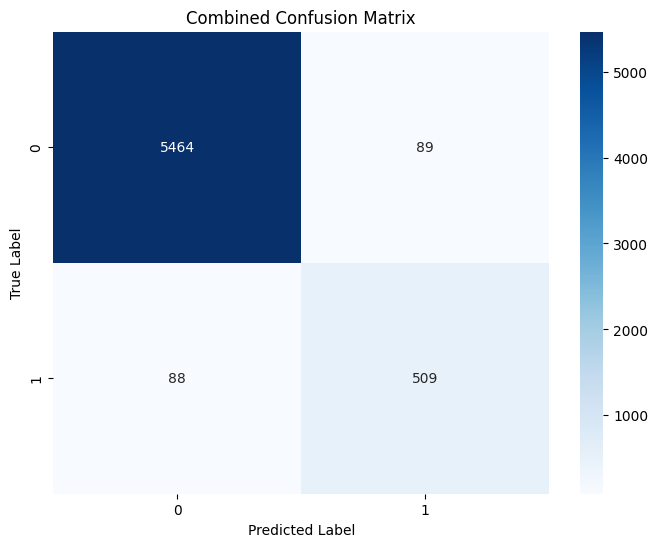

In [227]:
# Plot heatmap
plt.figure(figsize=(8, 6))  # Adjust width and height as needed
sns.heatmap(np.sum(flat_confusion_matrix, axis=0), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Combined Confusion Matrix')
plt.show()

In [231]:
# Sets path for exported data (numpy arrays)
DATA_PATH = os.path.join('all_lessons')

# Actions to detect (x actions multiplied by 30 frames multiplied by 30 sequences)
all_lessons_actions = np.array(['again', 'alive', 'bad', 'can', 'candy','dad', 'deaf', 'done', 'dont_like', 'dont_understand','family', 'friend', 
                                'go_to', 'good','happy','hard_of_hearing', 'hearing', 'help_me', 'how', 'hungry', 'i_love_you', 'like', 'love', 'mine', 
                                'mom', 'more', 'name', 'need', 'no', 'now', 'please', 'sad', 'school', 'slow', 'sorry', 'understand', 'wait', 'want',
                                'what', 'where', 'who', 'yes', 'you', 'yours'])

# Number of videos
num_sequences = 30

# Number of frames
sequence_length = 30

In [232]:
# Creates a dictionary of labels
all_lessons_label_map = {label:num for num, label in enumerate(all_lessons_actions)}

In [233]:
all_lessons_label_map

{'again': 0,
 'alive': 1,
 'bad': 2,
 'can': 3,
 'candy': 4,
 'dad': 5,
 'deaf': 6,
 'done': 7,
 'dont_like': 8,
 'dont_understand': 9,
 'family': 10,
 'friend': 11,
 'go_to': 12,
 'good': 13,
 'happy': 14,
 'hard_of_hearing': 15,
 'hearing': 16,
 'help_me': 17,
 'how': 18,
 'hungry': 19,
 'i_love_you': 20,
 'like': 21,
 'love': 22,
 'mine': 23,
 'mom': 24,
 'more': 25,
 'name': 26,
 'need': 27,
 'no': 28,
 'now': 29,
 'please': 30,
 'sad': 31,
 'school': 32,
 'slow': 33,
 'sorry': 34,
 'understand': 35,
 'wait': 36,
 'want': 37,
 'what': 38,
 'where': 39,
 'who': 40,
 'yes': 41,
 'you': 42,
 'yours': 43}

In [234]:
# Array of sequences (features) used to train model to represent relationship between labels
all_lessons_sequences, all_lessons_labels = [], []

# loops through each action
for action in all_lessons_actions:

    # Loops through each sequence
    for sequence_index in range(num_sequences):

        # Blank array to represent all frames for particular sequence
        window = []

        # Loops through each frame
        for frame_num in range(sequence_length):

            # Loads frame
            res = np.load(os.path.join(DATA_PATH, action, str(sequence_index), "{}.npy".format(frame_num)))

            # Add frames to window
            window.append(res)

        # Append video to sequences
        all_lessons_sequences.append(window)

        # Append lables
        all_lessons_labels.append(all_lessons_label_map[action])

In [235]:
# Stores sequences in array to make it easier to work with, uses x for x / y values
x_all_lessons = np.array(all_lessons_sequences)

# Converts labels to one encoded for y values
y_all_lessons = to_categorical(all_lessons_labels).astype(int) 

In [236]:
# Unpack results of train_test_split function with 5% of data
x_all_lessons_train, x_all_lessons_test, y_all_lessons_train, y_all_lessons_test = train_test_split(x_all_lessons, y_all_lessons, test_size=0.5)

In [237]:
# Create log directory
log_dir = os.path.join('all_lessons_logs')

# Set up TensorBoard callback
tb_callback = TensorBoard(log_dir=log_dir)

In [238]:
# Instantiates model
all_lessons_model = Sequential()

# Adds three sets of LSTM layers
all_lessons_model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
all_lessons_model.add(LSTM(128, return_sequences=True, activation='relu'))
all_lessons_model.add(LSTM(64, return_sequences=False, activation='relu'))

# Adds dense fully connected layers for fully connected neural network
all_lessons_model.add(Dense(64, activation='relu'))
all_lessons_model.add(Dense(32, activation='relu'))
all_lessons_model.add(Dense(all_lessons_actions.shape[0], activation='softmax'))

C:\Users\Owner\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [239]:
# Set up model for training and metrics for tracking
optimizer = Adam(learning_rate=0.0001)  # Set a lower learning rate
all_lessons_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [240]:
# Train model
all_lessons_model.fit(x_all_lessons_train, y_all_lessons_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - categorical_accuracy: 0.0321 - loss: 3.7831
Epoch 2/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - categorical_accuracy: 0.0572 - loss: 3.7658
Epoch 3/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - categorical_accuracy: 0.0349 - loss: 3.7419
Epoch 4/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - categorical_accuracy: 0.0471 - loss: 3.6945
Epoch 5/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - categorical_accuracy: 0.0471 - loss: 3.7050
Epoch 6/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - categorical_accuracy: 0.0661 - loss: 3.6183
Epoch 7/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - categorical_accuracy: 0.0918 - loss: 3.4974
Epoch 8/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - categorical_accuracy: 0.1046 - loss: 3.4245
Epoch 9/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - categorical_accuracy: 0.0960 - loss: 3.3550
Epoch 10/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - categorical_accuracy: 0.1140 - loss: 3.3270
Epoch 11/

In [121]:
# Save model
all_lessons_model.save('all_lessons.keras')

In [123]:
# Video feed for testing

# Appending to list collects 30 frames to generate prediction
sequence = []

# Allows concatenation of history 
sentence = []

predictions = []

# Only renders results if above a certain threshold
threshold = 0.7

# Function for opening the video feed
capture = cv2.VideoCapture(0) 

# Accesses mediapipe model
# Initial detection confidence & tracking confidence set
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # While the camera is opened
    while capture.isOpened():
        # Reads feed
        ret, frame = capture.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Extract keypoints from video
        keypoints = extract_keypoints(results)

        # Appending keypoints to sequence list
        sequence.append(keypoints)

        # Grabs the last 30 frames to generate a prediction
        sequence = sequence[-30:]

        # Run prediction only if the length of sequence equals 30
        if len(sequence) == 30:
            res = all_lessons_model.predict(np.expand_dims(sequence, axis=0))[0]
            predicted_action_index = np.argmax(res)
            predictions.append(predicted_action_index)

            # Visualization logic
            # If result above threshold
            if res[predicted_action_index] > threshold:
                sentence.append(all_lessons_actions[predicted_action_index])

        # If the sentence length is greater than 5
        if len(sentence) > 5:
            # Grab the last five values
            sentence = sentence[-5:]
            
        if len(sentence) > 0:
            cv2.putText(image, sentence[-1], (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

        # Shows to screen
        cv2.imshow('Open Camera Feed', image)

        # Break when 'q' pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Releases the camera feed, closes all windows
capture.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

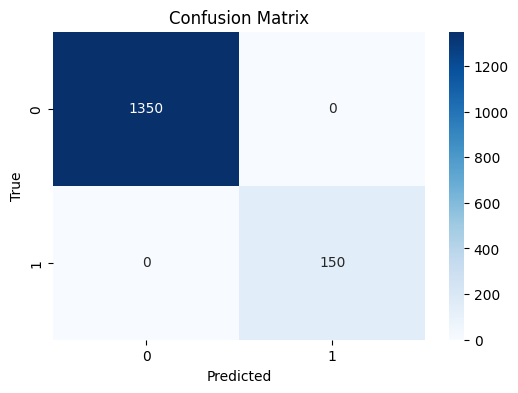

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have your confusion matrices stored in a list 'conf_matrices'
conf_matrices = [
    [[135,   0],
     [  0,  15]],

    [[141,   0],
     [  0,   9]],

    [[130,   0],
     [  0,  20]],

    [[134,   0],
     [  0,  16]],

    [[134,   0],
     [  0,  16]],

    [[134,   0],
     [  0,  16]],

    [[134,   0],
     [  0,  16]],

    [[133,   0],
     [  0,  17]],

    [[135,   0],
     [  0,  15]],

    [[140,   0],
     [  0,  10]]
]

# Convert the list of confusion matrices to a single 3-dimensional array
conf_matrix_array = np.array(conf_matrices)

# Sum along the first axis to aggregate the confusion matrices
conf_matrix_sum = np.sum(conf_matrix_array, axis=0)

# Plotting confusion matrix as a heatmap with smaller size
plt.figure(figsize=(6, 4))  # Adjust the figsize to make the heatmap smaller
sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues')

# Adding labels, title, and adjusting layout
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Displaying the heatmap
plt.show()


In [216]:
import cv2
import time

# Initialize the camera
camera = cv2.VideoCapture(0)  # 0 for the default camera, you can change this value if you have multiple cameras

# Check if the camera is opened successfully
if not camera.isOpened():
    print("Error: Unable to access the camera.")
    exit()

# Wait for 10 seconds
print("Waiting for 10 seconds before capturing the image...")
time.sleep(10)

# Capture a frame from the camera
ret, frame = camera.read()

# Check if the frame was captured successfully
if not ret:
    print("Error: Unable to capture frame.")
    exit()

# Display the captured frame (optional)
cv2.imshow("Captured Image", frame)
cv2.waitKey(0)  # Wait for a key press before closing the window

# Save the captured frame as an image
cv2.imwrite("captured_image.jpg", frame)

# Release the camera
camera.release()

# Close all OpenCV windows
cv2.destroyAllWindows()


Waiting for 10 seconds before capturing the image...


In [203]:
def plot_world_landmarks(
    plt,
    ax,
    landmarks,
    visibility_th=0.5,
    save_path=None  # Path to save the image
):
    landmark_point = []

    for index, landmark in enumerate(landmarks.landmark):
        landmark_point.append(
            [landmark.visibility, (landmark.x, landmark.y, landmark.z)])

    face_index_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    right_arm_index_list = [11, 13, 15, 17, 19, 21]
    left_arm_index_list = [12, 14, 16, 18, 20, 22]
    shoulder_index_list = [11, 12]

    # Face
    face_x, face_y, face_z = [], [], []
    for index in face_index_list:
        point = landmark_point[index][1]
        face_x.append(point[0])
        face_y.append(point[2])
        face_z.append(point[1] * (-1))

    # Right arm
    right_arm_x, right_arm_y, right_arm_z = [], [], []
    for index in right_arm_index_list:
        point = landmark_point[index][1]
        right_arm_x.append(point[0])
        right_arm_y.append(point[2])
        right_arm_z.append(point[1] * (-1))

    # Left arm
    left_arm_x, left_arm_y, left_arm_z = [], [], []
    for index in left_arm_index_list:
        point = landmark_point[index][1]
        left_arm_x.append(point[0])
        left_arm_y.append(point[2])
        left_arm_z.append(point[1] * (-1))

    # Shoulders
    shoulder_x, shoulder_y, shoulder_z = [], [], []
    for index in shoulder_index_list:
        point = landmark_point[index][1]
        shoulder_x.append(point[0])
        shoulder_y.append(point[2])
        shoulder_z.append(point[1] * (-1))

    ax.cla()
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)

    ax.scatter(face_x, face_y, face_z)
    ax.plot(right_arm_x, right_arm_y, right_arm_z)
    ax.plot(left_arm_x, left_arm_y, left_arm_z)
    ax.plot(shoulder_x, shoulder_y, shoulder_z)

    if save_path:
        plt.savefig(save_path)  # Save the plot as an image
    else:
        plt.show()

    return


In [142]:
plot_world_landmarks()

TypeError: plot_world_landmarks() missing 3 required positional arguments: 'plt', 'ax', and 'landmarks'

In [192]:
import cv2
import math
import numpy as np
import plotly.express as px
from pathlib import Path
import mediapipe as mp

# Define the path to the captured image
image_path = r"C:\Users\Owner\captured_image.jpg"

# Read the image with OpenCV.
image = cv2.imread(image_path)

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Run MediaPipe Pose and plot 3D pose world landmarks.
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2
) as pose:
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
    )
    cv2.imshow("Annotated Image", annotated_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


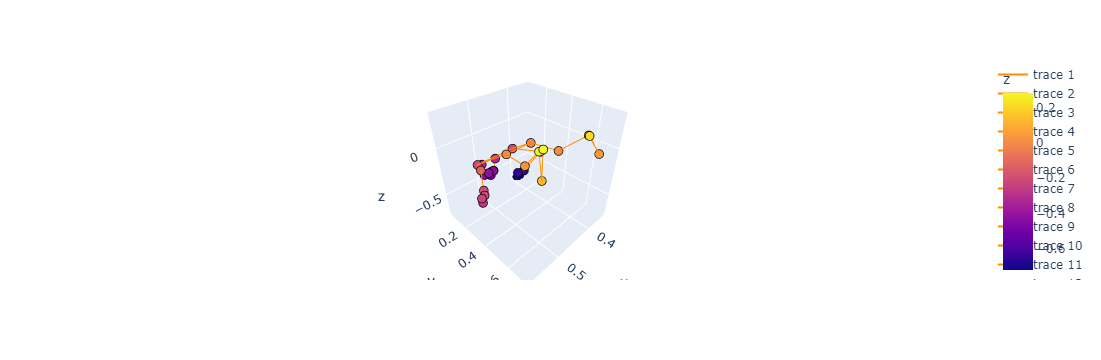

In [202]:
import cv2
import math
import numpy as np
import plotly.express as px
import pandas as pd
from pathlib import Path
import mediapipe as mp

# Define the path to the captured image
image_path = r"C:\Users\Owner\captured_image.jpg"

# Read the image with OpenCV.
image = cv2.imread(image_path)

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Run MediaPipe Pose and get the landmarks.
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2
) as pose:
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    landmarks = results.pose_landmarks.landmark

# Extract x, y, z coordinates of the landmarks
x = [landmark.x for landmark in landmarks]
y = [landmark.y for landmark in landmarks]
z = [landmark.z for landmark in landmarks]  

# Define connections between the landmarks
connections = mp_pose.POSE_CONNECTIONS

# Create a DataFrame with the landmark coordinates
data = {'x': x, 'y': y, 'z': z}
df = pd.DataFrame(data)

# Plot the landmarks in a 3D scatter plot using Plotly Express
fig = px.scatter_3d(df, x='x', y='y', z='z', color='z', size_max=10)

# Add connections between the landmarks
for connection in connections:
    start_index, end_index = connection
    start_x, start_y, start_z = x[start_index], y[start_index], z[start_index]
    end_x, end_y, end_z = x[end_index], y[end_index], z[end_index]
    fig.add_scatter3d(x=[start_x, end_x], y=[start_y, end_y], z=[start_z, end_z], mode='lines', line=dict(color='darkorange', width=2))

fig.update_traces(marker=dict(size=5, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=1)))
fig.show()


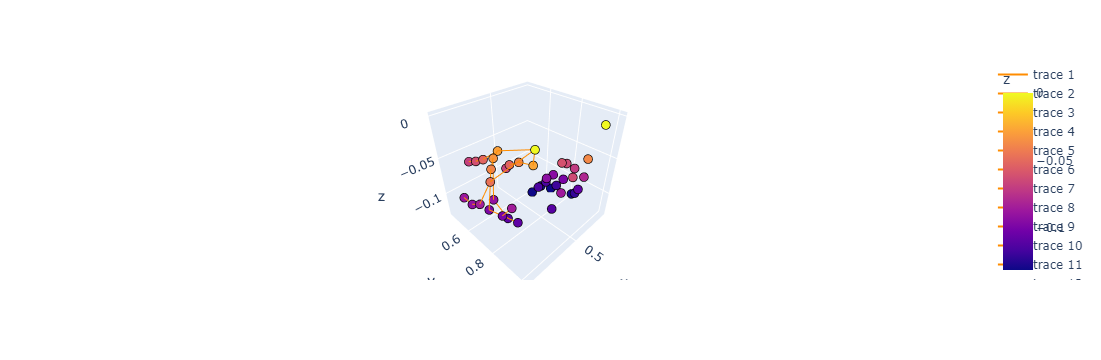

In [213]:
import cv2
import math
import numpy as np
import plotly.express as px
import pandas as pd
from pathlib import Path
import mediapipe as mp

# Define the path to the captured image
image_path = r"C:\Users\Owner\captured_image.jpg"

# Read the image with OpenCV.
image = cv2.imread(image_path)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Run MediaPipe Hands
with mp_hands.Hands(
    static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5
) as hands:
    results_hands = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Get hand landmarks
    landmarks_hands = []
    for hand_landmarks in results_hands.multi_hand_landmarks:
        landmarks_hands.extend(list(hand_landmarks.landmark))

# Extract x, y, z coordinates of the hand landmarks
x = [landmark.x for landmark in landmarks_hands]
y = [landmark.y for landmark in landmarks_hands]
z = [landmark.z for landmark in landmarks_hands]

# Define connections between the hand landmarks
connections_hands = list(mp_hands.HAND_CONNECTIONS)

# Create a DataFrame with the hand landmark coordinates
data = {'x': x, 'y': y, 'z': z}
df = pd.DataFrame(data)

# Plot the hand landmarks in a 3D scatter plot using Plotly Express
fig = px.scatter_3d(df, x='x', y='y', z='z', color='z', size_max=10)

# Add connections between the hand landmarks
for connection in connections_hands:
    start_index, end_index = connection
    start_x, start_y, start_z = x[start_index], y[start_index], z[start_index]
    end_x, end_y, end_z = x[end_index], y[end_index], z[end_index]
    fig.add_scatter3d(x=[start_x, end_x], y=[start_y, end_y], z=[start_z, end_z], mode='lines', line=dict(color='darkorange', width=2))

fig.update_traces(marker=dict(size=5, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=1)))
fig.show()


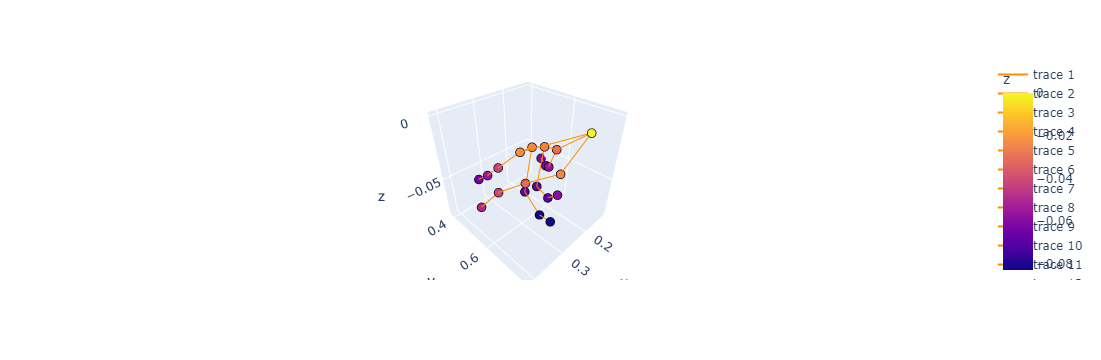

In [217]:
import cv2
import math
import numpy as np
import plotly.express as px
import pandas as pd
from pathlib import Path
import mediapipe as mp

# Define the path to the captured image
image_path = r"C:\Users\Owner\captured_image.jpg"

# Read the image with OpenCV.
image = cv2.imread(image_path)

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Run MediaPipe Hands
with mp_hands.Hands(
    static_image_mode=True, min_detection_confidence=0.5, min_tracking_confidence=0.5
) as hands:
    results_hands = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Get hand landmarks
    landmarks_hands = []
    for hand_landmarks in results_hands.multi_hand_landmarks:
        landmarks_hands.extend(list(hand_landmarks.landmark))

# Extract x, y, z coordinates of the hand landmarks
x = [landmark.x for landmark in landmarks_hands]
y = [landmark.y for landmark in landmarks_hands]
z = [landmark.z for landmark in landmarks_hands]

# Define connections between the hand landmarks
connections_hands = list(mp_hands.HAND_CONNECTIONS)

# Create a DataFrame with the hand landmark coordinates
data = {'x': x, 'y': y, 'z': z}
df = pd.DataFrame(data)

# Plot the hand landmarks in a 3D scatter plot using Plotly Express
fig = px.scatter_3d(df, x='x', y='y', z='z', color='z', size_max=10)

# Add connections between the hand landmarks
for connection in connections_hands:
    start_index, end_index = connection
    start_x, start_y, start_z = x[start_index], y[start_index], z[start_index]
    end_x, end_y, end_z = x[end_index], y[end_index], z[end_index]
    fig.add_scatter3d(x=[start_x, end_x], y=[start_y, end_y], z=[start_z, end_z], mode='lines', line=dict(color='darkorange', width=2))

fig.update_traces(marker=dict(size=5, line=dict(width=2, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=1)))
fig.show()
